In [1]:
import time
import math
import argparse
import random
import numpy as np

from swarm import Swarm

#TODO: add constraints to drone position

showDiagrams = True

In [2]:
#ArgParser:
parser = argparse.ArgumentParser(description="Example script with argparse")

parser.add_argument('--outputFile', type=str,default='../data/logs/defaultLogfile', help='Path where the output should be stored')
parser.add_argument('--numDrones', type=int, default=10, help='Number of Drones used')

parser.add_argument('--popSize', type=int, default=10, help='Population Size of each Generation')
parser.add_argument('--numGenerations', type=int, default=10, help='Number of Generations')
parser.add_argument('--worldFile', type=str, default='world100Forest', help='name of the world file without sdf')
parser.add_argument('--maxRuns', type=int, default=10, help='maximum number of runs')
parser.add_argument('--movementType', type=int, default=1, help='0: Static \n1: Line \n2: random')

args, unknown = parser.parse_known_args()

In [3]:
#Starts the simulation as a separate thread

import time, select
from subprocess import Popen,PIPE,run
import subprocess
  
process = Popen(['gz','sim', f"../worlds/{args.worldFile}.sdf", '-r','-s'], stdout=PIPE, stderr=PIPE, text=True)
showDiagrams = False


In [3]:
NUM_DRONES = args.numDrones

GRID_SIZE = 100       # Size of the Forest

CAMERA_FOV_DEGREE = 50
IMAGE_SIZE = 512 #How many Scanning points each image has per Row (Images are 512x512)

DRONE_HEIGHT = 35

POPULATION_SIZE = args.popSize
NUM_GENERATIONS = args.numGenerations
MUTATION_RATE = 0.1
MOVEMENT_TYPE = args.movementType

maxRuns = args.maxRuns



camera_fov=np.deg2rad(CAMERA_FOV_DEGREE)
camera_offset= 35 * np.tan(camera_fov/2)




#each "Step" is 10 seconds in this Example

#How far the drones should move each step at maximum
DRONE_STEPSIZE= 15
#
#How far the target could move each stepsize (Sigma+=Stepsize)
TARGET_STEPSIZE= 7

#How many Drones should see the same points for it to count as "seen"
seenPercentage = 1/NUM_DRONES*2

#ideal size of Scanned area
#larger areas get a worse score, smaller areas a better score
idealSize = 1024**2

start = time.time()

In [4]:

grid_offset=GRID_SIZE/2
camera_fov=np.deg2rad(CAMERA_FOV_DEGREE)
camera_offset= 35 * np.tan(camera_fov/2)
prob_array_size= int(np.ceil((GRID_SIZE*512)/(camera_offset*2)))
def getProbabilityGrid(Last_Known_Position, sigma):
    #Create Target Probability Grid
    x = np.linspace(-grid_offset, grid_offset, prob_array_size)
    y = np.linspace(-grid_offset, grid_offset, prob_array_size)
    x, y = np.meshgrid(x, y)

    prob_density = (1 / (np.sqrt(2 * np.pi)* sigma)) * np.exp(-((x - Last_Known_Position[0])**2 + (y - Last_Known_Position[1])**2) / (2 * sigma**2))

    return prob_density,x,y

In [5]:
#Spawn Drones and move to initial position

# Create the swarm object by passing the name
# of the world from the .sdf world file.
swarm = Swarm(args.worldFile)

Subscribed successfully


In [6]:


# Spawn X drones and keep the returning ids as handles
#ids = swarm.spawn(NUM_DRONES)
print(f"Trying to spawn {NUM_DRONES*POPULATION_SIZE} Drones")
tries = 0
notStarted = True
ids = 0
while notStarted and tries<15:
    try:
        ids = swarm.spawn(NUM_DRONES*POPULATION_SIZE)
        notStarted = False
        #print(ids)
    except Exception as e:
        print(f"Sim not ready after {tries} minutes, sleeping for 1 minute")
        print(e)
        time.sleep(60)
        tries = tries+1
if tries>=15:
    raise Exception("Simulation couldnt be started after 15 minutes")
    
print("Drones Spawned Sucessfully")



Trying to spawn 100 Drones
Sim not ready after 0 minutes, sleeping for 1 minute
Request to spawn drones timed out!
Drones Spawned Sucessfully


In [7]:
def update_Target_Position_random(Target_Position):
    print(f"Position before: {Target_Position}")
    #creates a random vector, scales it to TARGET_STEPSIZE and adds it to target Position
    new_x = random.uniform(-1, 1)
    new_y = random.uniform(-1, 1)
            
    # Calculate the distance from the first coordinate
    dist = distance([0,0], [new_x, new_y])
    random_vec = np.array([new_x,new_y])
    print(f"random vec{random_vec}, dist: {dist}")
    newPos = Target_Position+((random_vec/dist)*TARGET_STEPSIZE)
    newPos = np.clip(newPos, -40, 40)
    print(f"New Pos: {newPos}")
    return newPos

    
def update_Target_Position_line(Target_Position):
    
    if (distance(Target_Position, goal_position) > TARGET_STEPSIZE):
        Target_Position = Target_Position + movement_vector
    return Target_Position


def distance(a, b):
    # Calculate the Euclidean distance between two points
    return math.sqrt((b[0]-a[0])**2+(b[1]-a[1])**2)


# minimum distance from initial target position, maximum range 
def generate_goal_coordinate(Target_Position, min_distance=70, boundary=(-40, 40)):
    while True:
        # Generate random x and y within the boundary [-40, 40]
        new_x = random.uniform(boundary[0], boundary[1])
        new_y = random.uniform(boundary[0], boundary[1])
        
        # Calculate the distance from the first coordinate
        dist = distance(Target_Position, (new_x, new_y))
        
        # Check if the distance is at least 50 units
        if dist >= min_distance:
            goal_position = np.array([new_x, new_y])
            movement_vector = ((goal_position-Target_Position)/dist)*TARGET_STEPSIZE
            print(f"Target is moving towards {goal_position} (Distance: {dist}) with vector {movement_vector}")
            return goal_position, movement_vector

In [8]:
print(update_Target_Position_random([10,10]))

Position before: [10, 10]
random vec[0.0330855  0.11375297], dist: 0.1184668217227171
New Pos: [11.954965  16.7214665]
[11.954965  16.7214665]


In [9]:
#Initialize Target Position

#maximum distance from center for the target
maximumTarget = 35
#minimum distance for the target
minimumTarget = 15

def generate_random_coordinate():
    while True:
        # Generate random x and y between -35 and 35
        x = random.uniform(-maximumTarget, maximumTarget)
        y = random.uniform(-maximumTarget, maximumTarget)
        
        # Check if the point is outside the range [-10, 10] for both x and y
        if not (-minimumTarget <= x <= minimumTarget) and not(-minimumTarget <= y <= minimumTarget):
            return np.array([x, y])

Target_Position = generate_random_coordinate()

Last_Known_Position = Target_Position
print(f"Target is at position {Target_Position}")
initial_Target = Target_Position

goal_position,movement_vector = generate_goal_coordinate(Target_Position)


updateTargetPosition = update_Target_Position_line
if(MOVEMENT_TYPE==2):
    print("using random movement")
    updateTargetPosition =update_Target_Position_random

# First waypoints
waypoints = np.empty((0,3),float)
for i in range (NUM_DRONES):
    waypoints= np.append(waypoints,np.array([[math.ceil(i-(NUM_DRONES/2)),0.0,DRONE_HEIGHT]]), axis=0)

#create Initial
#swarm.waypoints(ids, waypoints)

#Create Target Probability Grid
sigma= 10

prob_density,x,y = getProbabilityGrid(Last_Known_Position,sigma)

#print(prob_density)

Target is at position [-17.81380549  19.97081887]
Target is moving towards [ 32.53487666 -39.09775779] (Distance: 77.61498916550572) with vector [ 4.54088545 -5.32732197]


In [10]:
# Problem classes
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

# Algorithmss
from pymoo.algorithms.soo.nonconvex.de import DE

# Survival operators
from pymoo.operators.sampling.lhs import LHS

In [11]:
#return percentage of ground visible (depth>34meter)
def check_ground_visibility(depth_image):
    number_visible_ground=0
    for i in depth_image:
        for j in i:
            if j[0]>3400:
                number_visible_ground= number_visible_ground+1
    return number_visible_ground/(512**2)
 

#Gives Coordinates based on drone position and scan pixel
def calculate_world_coordinates(drone_pos, image_radius, img_x, img_y):
    pos_x = drone_pos[0] + (img_x-256)/512 * image_radius * 2
    pos_y = drone_pos[1] + (img_y-256)/512 * image_radius * 2
    return (pos_x, pos_y)

In [12]:
def getOverlapArray(waypoints,offset,img_width=512,img_height=512):
    
    MinX = [0,float('inf')]
    MaxX = [0,float('-inf')]
    MinY = [0,float('inf')]
    MaxY = [0,float('-inf')]
    
    for i in range(len(waypoints)):
        x = waypoints[i][0]
        y = waypoints[i][1]
        #Determine the Minimum X,Y and Maximum X,Y of the sampling positions and saves which drone
        if (x < MinX[1]):
            MinX = [i, x]
        if (x > MaxX[1]):
            MaxX = [i, x]
        if (y < MinY[1]):
            MinY = [i, y]
        if (y > MaxY[1]):
            MaxY = [i, y]
    
    MinX[1] = calculate_world_coordinates(waypoints[MinX[0]], camera_offset, 0,0)[0]
    MaxX[1] = calculate_world_coordinates(waypoints[MaxX[0]], camera_offset, img_width,img_height)[0]
    MinY[1] = calculate_world_coordinates(waypoints[MinY[0]], camera_offset, 0,0)[1]
    MaxY[1] = calculate_world_coordinates(waypoints[MaxY[0]], camera_offset, img_width, img_height)[1]  
    
    #gets the needed width/height of the array based on the distance between smallest and largest X/Y Value, rounding up
    array_width = int(np.ceil(((MaxX[1]-MinX[1])*img_width)/(camera_offset*2)))
    array_height = int(np.ceil(((MaxY[1]-MinY[1])*img_height)/(camera_offset*2)))

    #fills the array with zeroes
    visibility_array = np.zeros((int(array_width), (int(array_height))))
    
    visibility_threshold= 3400 #once depth is higher than this value, the ground counts as seen
    
    #adds 1/NUM_DRONES if the point is seen
    #print(ids[0])
    firstID = ids[0]
    
    for id in range(len(waypoints)):       
        for i in range(img_width):
            for j in range(img_height):
                #print(f"ID: {id+(offset*NUM_DRONES)}     value: {swarm.depth_images[id+(offset*NUM_DRONES)][i][j][0]} ")
                if swarm.depth_images[firstID+id+(offset*NUM_DRONES)][i][j][0] > visibility_threshold:
                    world_x, world_y = calculate_world_coordinates(waypoints[id], camera_offset, j, i)
                    try:
                        world_x_idx = int(((world_x - MinX[1]) / (MaxX[1] - MinX[1])) * array_width)
                        world_y_idx = int(((world_y - MinY[1]) / (MaxY[1] - MinY[1])) * array_height)
                    except Exception as e:
                        print(f"Something went wrong, Exception: {e}\ncurrent coordiantes: world_x: {world_x}, world_y: {world_y}")
                        
                    
                    if 0 <= world_x_idx < array_width and 0 <= world_y_idx < array_height:
                        visibility_array[world_x_idx][world_y_idx] += 1/NUM_DRONES


    visibility_offset_x=int(((MinX[1]+grid_offset)/GRID_SIZE)*prob_array_size)
    visibility_offset_y=int(((MinY[1]+grid_offset)/GRID_SIZE)*prob_array_size)
    
    visibility_offset=[visibility_offset_x,visibility_offset_y]
    
    #get X/Y of target
    target_x_idx = int(((Target_Position[0] - MinX[1]) / (MaxX[1] - MinX[1])) * array_width)
    target_y_idx = int(((Target_Position[1] - MinY[1]) / (MaxY[1] - MinY[1])) * array_height)
    
    targetXY= [target_x_idx,target_y_idx]
    
    #print(f"target is at [{Target_Position}], corresponding to {targetXY}, in the array of size [{array_width},{array_height}]")
    
    #print(f"Waypoints: \n{waypoints}\n")
    #print(f"Edges: [{MinX},{MaxX}] [{MinY},{MaxY}\n")
    
    return visibility_array, visibility_offset, targetXY
    


In [13]:
def scoreThatThing(prob_density,visibility_grid,visibility_offset, targetXY):
     
    scoringArray=np.zeros(prob_density.shape)
    score=0
    targetSeen = False
    
    #how far away from target position it gets detected
    targetRange = 4
    
    
    #print(f"Visibility Grid is of shape {visibility_grid.shape}")
    
    for i in range(visibility_grid.shape[0]):
        for j in range(visibility_grid.shape[1]):
            visibility_Value=visibility_grid[i][j]           
            
            #only add score if >2 the drones see square
            try:
                if visibility_Value>=seenPercentage:
                    tileScore = prob_density[i+visibility_offset[0]][j+visibility_offset[1]]*visibility_Value

                    if i-targetRange<=targetXY[0]<=i+targetRange and j-targetRange<=targetXY[1]<=j+targetRange:
                        targetSeen=True
                        #print("Saw somehting!")
                        score+=(tileScore*1000)
                        scoringArray[i][j]=tileScore*1000
                    else:
                        score+=tileScore
                        scoringArray[i][j]=tileScore
            except:
                #if it scans something "outside" of the scan area it skips the points
                break
                
    if targetSeen:
        score+= 5000
        
    #scale score based on size                
    size = visibility_grid.shape[0]*visibility_grid.shape[1]
    scoring_factor = idealSize/size
    
    #print(f"SCoring factor would be: {scoring_factor}")
    score = score * scoring_factor
    return score, targetSeen,scoringArray

In [14]:
evalTimings= []
overlapTimings = []
scoringTimings = [] 
waypointTimings = []

class MyProblem(Problem):

    def __init__(self, grid_size, n_drones, n_steps,waypoints,prob_density):
        
        self.grid_size = grid_size
        self.n_drones = n_drones
        n_var=2*n_drones
        self.n_steps = n_steps
        
        self.waypoints = waypoints
        self.prob_density = prob_density
        
        super().__init__(
            n_var=n_var,  # Variables in the solutions (x,y)
            n_obj=1,      # Number of Objectives we wanna optimize
            n_constr=0,   # No additional constraints, TODO: add no crashing into eachother
            xl=0,      # Lower boundaries of solution variables
            xu=1,       # Upper bounds of solution vars
        )    

        #x are the waypoints
    def _evaluate(self, x, out, *args, **kwargs):
        
        evalTime_start = time.time()
        
        scores = np.zeros(POPULATION_SIZE)
        seenAr = np.zeros(POPULATION_SIZE)
        visibilityAr = []
        scoringAr = []
        #scales the variables to  [-2,2]
        _x= np.array(x)*4-2
        #reshapes the variables back into a waypoint array
        coordinates = _x.reshape(-1, 2)        
        
        #adds a 0 for height to the coordinates
        padded_coordiantes = np.pad(coordinates,((0, 0), (0, 1)),mode='constant',constant_values=0)
        
        #limits drone movement to area
        padded_coordiantes = np.clip(padded_coordiantes, -GRID_SIZE/2, GRID_SIZE/2)
        
        #tiles the waypoints and adds the moves, then sends all waypoints(NUM_DRONES*POPULATION_SIZE) to the simulation
        tempWaypoints = np.tile(waypoints,(POPULATION_SIZE,1)) + padded_coordiantes
        swarm.waypoints(ids,tempWaypoints)
        
        isScored = False
        score = None
        
        waypoint_start = time.time()
        #print(ids)
        while not isScored:
            #wait until all drones received
            
            if swarm.received_frames[ids[-1]]:
                waypointTimings.append(time.time()-waypoint_start)
                #print(f"Frames received after {time.time()-evalTime_start} seconds")
                for i in range(POPULATION_SIZE):
                    solutionWaypoints = tempWaypoints[i*NUM_DRONES:(i+1)*NUM_DRONES]
                    
                    #time start
                    overlap_start = time.time()
                    visibility_grid,visibility_offset, targetXY = getOverlapArray(solutionWaypoints,offset=i)
                    overlapTimings.append(time.time()-overlap_start)
                    
                    scoring_start = time.time()
                    score, _wasSeen,scoringArray = scoreThatThing(self.prob_density,visibility_grid,visibility_offset,targetXY)
                    scoringTimings.append(time.time()-scoring_start)
                    
                    scores[i] = -score
                    seenAr[i] = _wasSeen
                    
                    visibilityAr.append(copy.deepcopy(visibility_grid))
                    scoringAr.append(copy.deepcopy(scoringArray))
                isScored=True
        
        out["F"] = scores
        out["aux1"] = seenAr
        out["aux2"] = visibilityAr
        out["aux3"] = scoringAr
        
        evalTimings.append(time.time()-evalTime_start)   
        #print(f"the average evaluation time per generation was {np.mean(evalTimings)} seconds")
        #print(f"the average waypointTimings was {np.mean(waypointTimings)} seconds")
        #print(f"the average overlapTimings per Solution Individual was {np.mean(overlapTimings)} seconds")
        #print(f"the average scoringTimings per Solution Individual was {np.mean(scoringTimings)} seconds")
        

In [15]:
from pymoo.core.sampling import Sampling
class MySampling(Sampling):

    def _do(self, problem, n_samples, **kwargs):
        X = [np.random.rand(problem.n_var)]
        #X = np.array(0)
        for i in range(n_samples-1):
            X= np.append(X,[np.random.rand(problem.n_var)], axis=0)
        return X
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", NUM_GENERATIONS)

In [16]:
problem = MyProblem(GRID_SIZE, NUM_DRONES, NUM_GENERATIONS, waypoints, prob_density)

algorithm = DE(
    pop_size=POPULATION_SIZE,
    sampling=MySampling(),    #Für initiale Population
    variant="DE/rand/1/bin",
    CR=0.9,
    F=0.8,
    dither="vector"
)

In [17]:
import matplotlib.pyplot as plt
import copy

Starting now, at 66.45001029968262
Run 1


/home/user/.local/lib/python3.7/site-packages/pymoo/core/problem.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  v = np.array(v)


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.885484E+02 | -6.655107E+02
     2 |       20 | -6.227308E+02 | -6.823553E+02


/home/user/.local/lib/python3.7/site-packages/pymoo/core/problem.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  v = np.array(v)


     3 |       30 | -6.436721E+02 | -6.823553E+02
     4 |       40 | -6.460553E+02 | -6.823553E+02
     5 |       50 | -6.585275E+02 | -6.886787E+02
     6 |       60 | -6.737384E+02 | -6.972277E+02
     7 |       70 | -6.930272E+02 | -7.773150E+02
     8 |       80 | -6.988361E+02 | -7.773150E+02
     9 |       90 | -7.220165E+02 | -7.773150E+02
    10 |      100 | -7.463294E+02 | -7.895656E+02
Target is now at [-13.27292004  14.6434969 ]
Visibility Grid of Best solution:


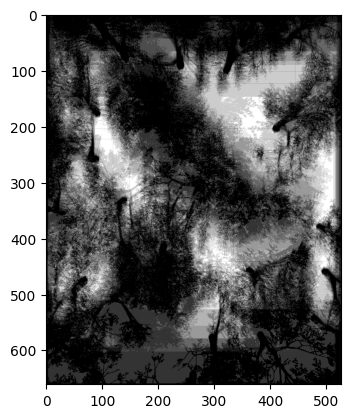

Scoring Grid of Best solution: 




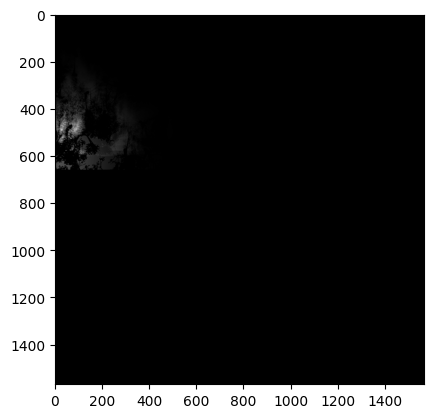

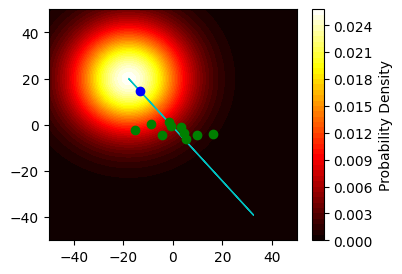

Run 2
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -8.950815E+03 | -9.634103E+03
     2 |       20 | -9.124593E+03 | -9.634103E+03
     3 |       30 | -9.301155E+03 | -9.634103E+03
     4 |       40 | -9.431840E+03 | -9.660977E+03
     5 |       50 | -9.479772E+03 | -9.703379E+03
     6 |       60 | -9.506874E+03 | -9.703379E+03
     7 |       70 | -9.536026E+03 | -9.703379E+03
     8 |       80 | -9.587168E+03 | -1.009850E+04
     9 |       90 | -9.669089E+03 | -1.009850E+04
    10 |      100 | -9.778754E+03 | -1.017947E+04
Target is now at [-8.73203459  9.31617494]
Target Seen!
Updating target Position and resetting Sigma
Visibility Grid of Best solution:


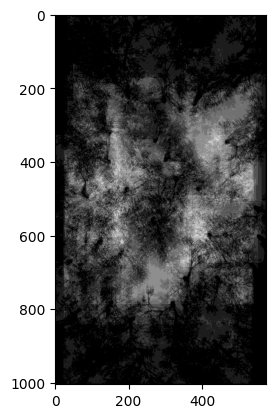

Scoring Grid of Best solution: 




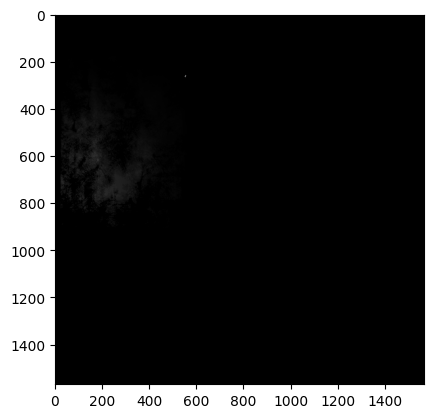

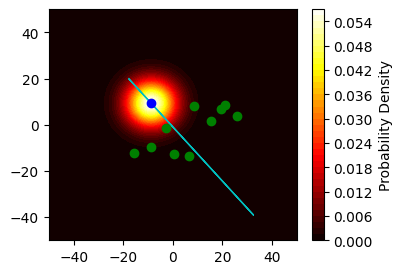

Run 3
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.108343E+03 | -5.932303E+03
     2 |       20 | -3.181943E+03 | -5.965714E+03
     3 |       30 | -4.755111E+03 | -6.098241E+03
     4 |       40 | -4.807826E+03 | -6.213783E+03
     5 |       50 | -5.893999E+03 | -6.213783E+03
     6 |       60 | -5.999109E+03 | -6.240673E+03
     7 |       70 | -6.032156E+03 | -6.240673E+03
     8 |       80 | -6.099815E+03 | -6.315851E+03
     9 |       90 | -6.180651E+03 | -6.370910E+03
    10 |      100 | -6.194180E+03 | -6.370910E+03
Target is now at [-4.19114914  3.98885297]
Target Seen!
Updating target Position and resetting Sigma
Visibility Grid of Best solution:


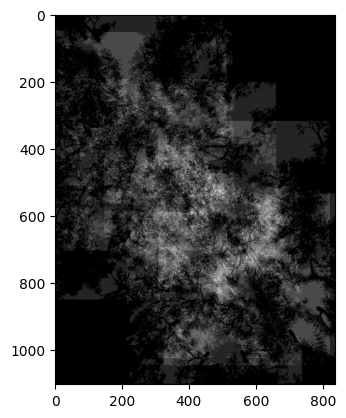

Scoring Grid of Best solution: 




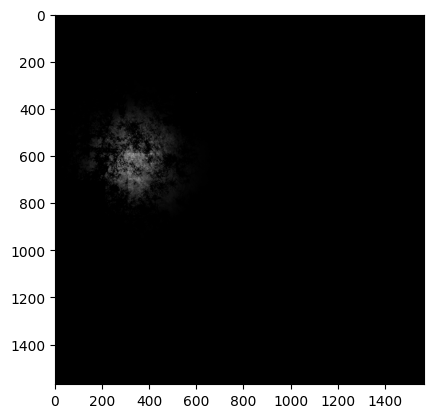

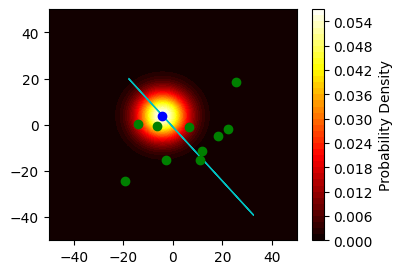

Run 4
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -4.203169E+03 | -4.400123E+03
     2 |       20 | -4.287507E+03 | -4.424010E+03
     3 |       30 | -4.315893E+03 | -4.424010E+03
     4 |       40 | -4.333108E+03 | -4.424010E+03
     5 |       50 | -4.389468E+03 | -4.485340E+03
     6 |       60 | -4.409675E+03 | -4.496457E+03
     7 |       70 | -4.413923E+03 | -4.496457E+03
     8 |       80 | -4.439317E+03 | -4.548006E+03
     9 |       90 | -4.459109E+03 | -4.621045E+03
    10 |      100 | -4.504265E+03 | -4.639921E+03
Target is now at [ 0.34973631 -1.33846899]
Target Seen!
Updating target Position and resetting Sigma
Visibility Grid of Best solution:


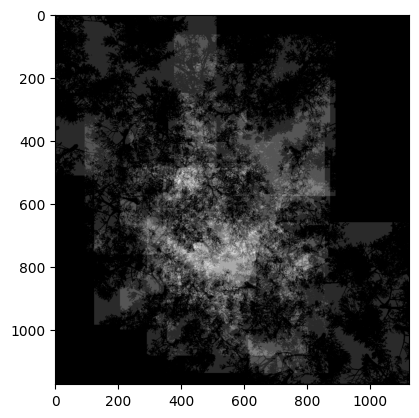

Scoring Grid of Best solution: 




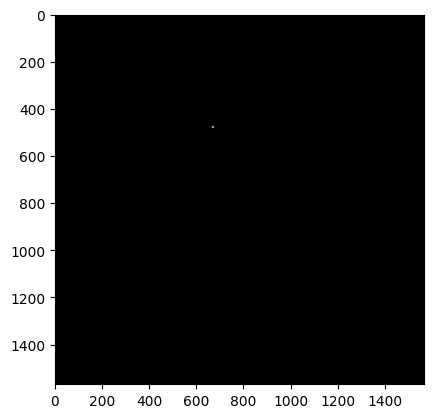

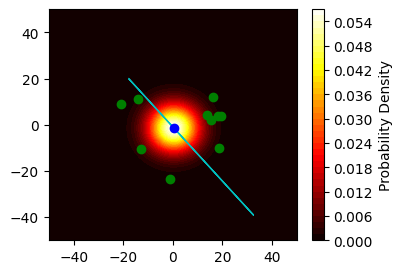

Run 5
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -4.802926E+03 | -5.218371E+03
     2 |       20 | -4.878007E+03 | -5.235097E+03
     3 |       30 | -4.951681E+03 | -5.235097E+03
     4 |       40 | -5.026558E+03 | -5.235097E+03
     5 |       50 | -5.056083E+03 | -5.235097E+03
     6 |       60 | -5.072798E+03 | -5.235097E+03
     7 |       70 | -5.182904E+03 | -5.374863E+03
     8 |       80 | -5.198768E+03 | -5.374863E+03
     9 |       90 | -5.275608E+03 | -5.454562E+03
    10 |      100 | -5.333316E+03 | -5.539942E+03
Target is now at [ 4.89062176 -6.66579096]
Target Seen!
Updating target Position and resetting Sigma
Visibility Grid of Best solution:


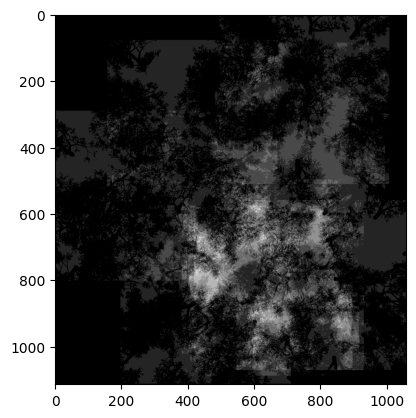

Scoring Grid of Best solution: 




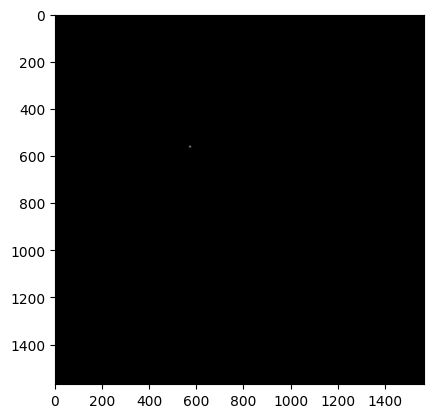

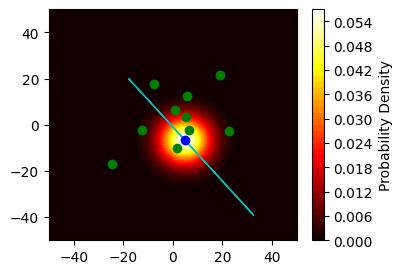

Run 6
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -3.683026E+03 | -4.607718E+03
     2 |       20 | -4.471084E+03 | -4.646400E+03
     3 |       30 | -4.543864E+03 | -4.732491E+03
     4 |       40 | -4.640923E+03 | -4.806104E+03
     5 |       50 | -4.683937E+03 | -4.806104E+03
     6 |       60 | -4.713877E+03 | -4.814774E+03
     7 |       70 | -4.743819E+03 | -4.814774E+03
     8 |       80 | -4.743821E+03 | -4.814774E+03
     9 |       90 | -4.781880E+03 | -4.837176E+03
    10 |      100 | -4.806850E+03 | -4.957033E+03
Target is now at [  9.43150721 -11.99311293]
Target Seen!
Updating target Position and resetting Sigma
Visibility Grid of Best solution:


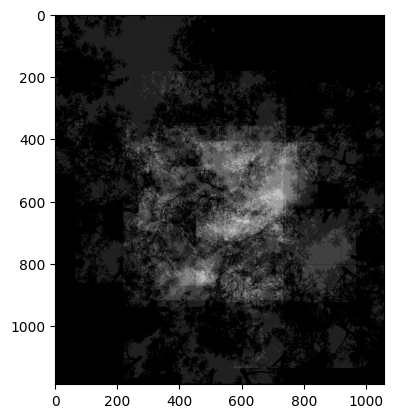

Scoring Grid of Best solution: 




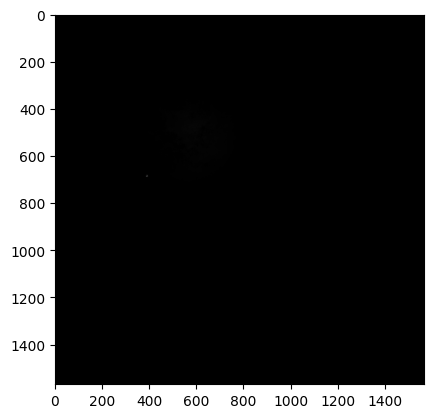

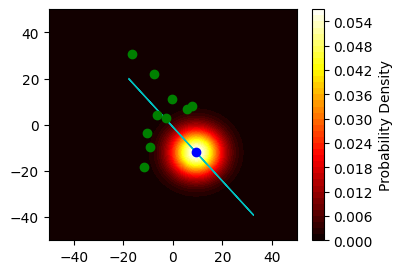

Run 7
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -2.803358E+03 | -5.745536E+03
     2 |       20 | -3.318222E+03 | -5.787223E+03
     3 |       30 | -4.295897E+03 | -5.787223E+03
     4 |       40 | -4.322665E+03 | -5.932590E+03
     5 |       50 | -5.277125E+03 | -5.932590E+03
     6 |       60 | -5.337073E+03 | -5.951964E+03
     7 |       70 | -5.835476E+03 | -5.970083E+03
     8 |       80 | -5.879273E+03 | -6.046543E+03
     9 |       90 | -5.931286E+03 | -6.046543E+03
    10 |      100 | -5.966374E+03 | -6.074247E+03
Target is now at [ 13.97239266 -17.32043489]
Target Seen!
Updating target Position and resetting Sigma
Visibility Grid of Best solution:


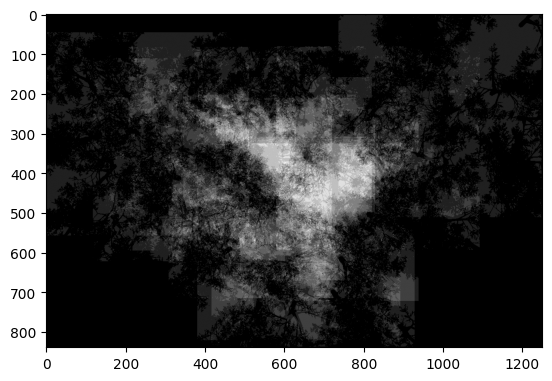

Scoring Grid of Best solution: 




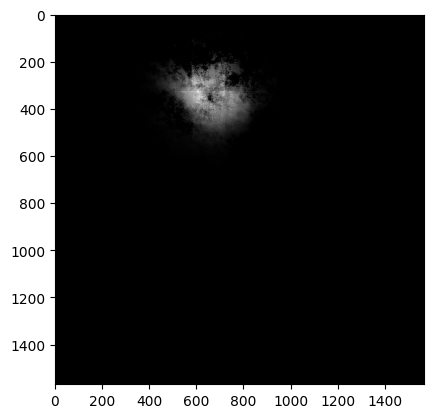

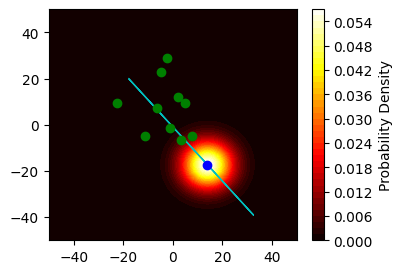

Run 8
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -3.532156E+03 | -5.586893E+03
     2 |       20 | -5.097850E+03 | -5.910862E+03
     3 |       30 | -5.678400E+03 | -5.960881E+03
     4 |       40 | -5.766568E+03 | -6.011863E+03
     5 |       50 | -5.830999E+03 | -6.011863E+03
     6 |       60 | -5.867630E+03 | -6.011863E+03
     7 |       70 | -5.918277E+03 | -6.037733E+03
     8 |       80 | -5.922933E+03 | -6.037733E+03
     9 |       90 | -6.036578E+03 | -6.307391E+03
    10 |      100 | -6.116161E+03 | -6.311814E+03
Target is now at [ 18.51327811 -22.64775686]
Target Seen!
Updating target Position and resetting Sigma
Visibility Grid of Best solution:


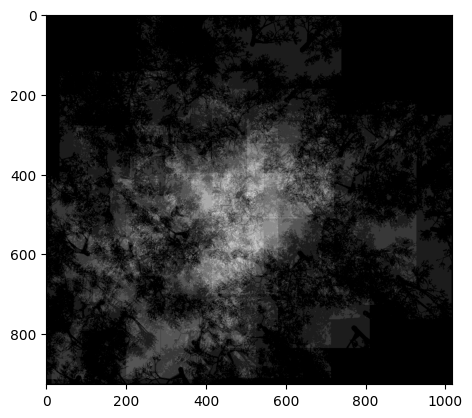

Scoring Grid of Best solution: 




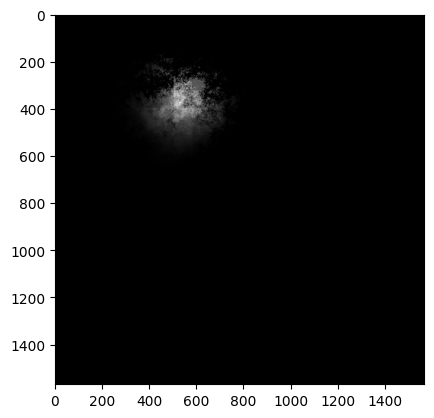

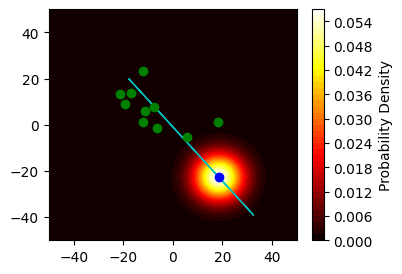

Run 9
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.917575E+02 | -6.371445E+02
     2 |       20 | -6.073125E+02 | -6.371445E+02
     3 |       30 | -6.204857E+02 | -6.371445E+02
     4 |       40 | -6.239976E+02 | -6.483958E+02
     5 |       50 | -6.297421E+02 | -6.755469E+02
     6 |       60 | -6.379230E+02 | -6.755469E+02
     7 |       70 | -6.468492E+02 | -6.836370E+02
     8 |       80 | -6.481602E+02 | -6.836370E+02
     9 |       90 | -6.500457E+02 | -7.024918E+02
    10 |      100 | -6.651955E+02 | -7.024918E+02
Target is now at [ 23.05416356 -27.97507882]
Visibility Grid of Best solution:


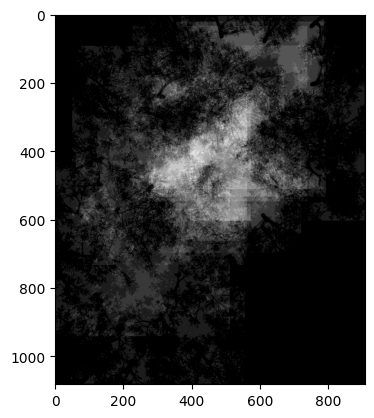

Scoring Grid of Best solution: 




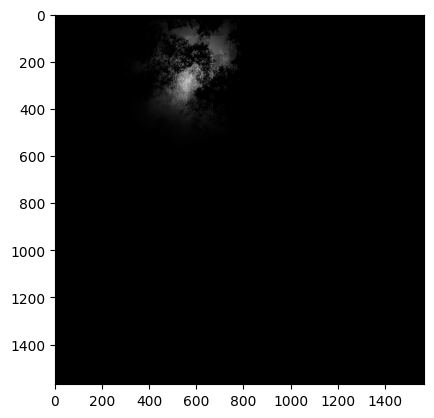

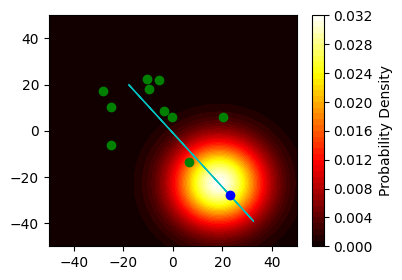

Run 10
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | -5.089833E+02 | -5.501623E+02
     2 |       20 | -5.313799E+02 | -5.721924E+02
     3 |       30 | -5.517533E+02 | -5.936268E+02
     4 |       40 | -5.653489E+02 | -5.993019E+02
     5 |       50 | -5.783797E+02 | -6.181342E+02
     6 |       60 | -5.955487E+02 | -6.227866E+02
     7 |       70 | -6.076130E+02 | -6.494270E+02
     8 |       80 | -6.131941E+02 | -6.494270E+02
     9 |       90 | -6.224376E+02 | -6.494270E+02
    10 |      100 | -6.300217E+02 | -6.494270E+02
Target is now at [ 27.59504901 -33.30240079]
Visibility Grid of Best solution:


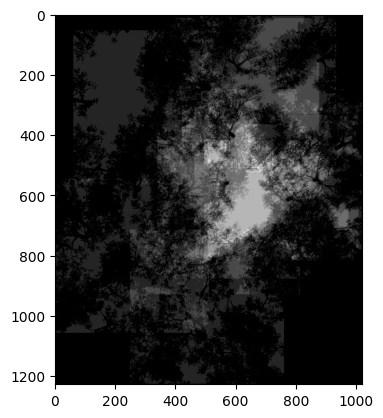

Scoring Grid of Best solution: 




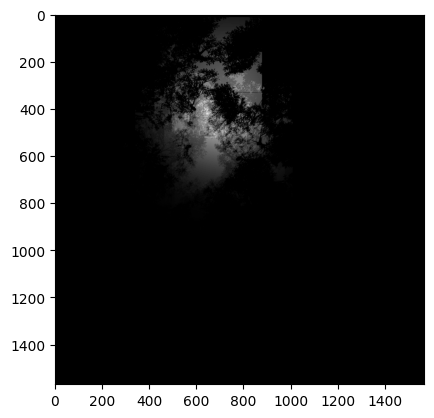

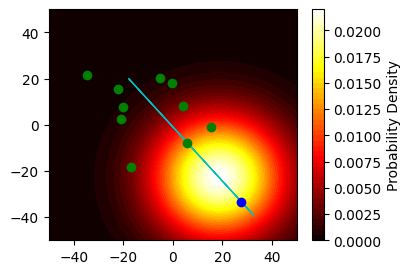

Drone Path:
[array([[[  4.65737625,  -3.46951174,  35.        ],
        [ -1.41301882,   1.26102487,  35.        ],
        [-15.44031341,  -2.31454408,  35.        ],
        [ -0.68944983,  -0.73265052,  35.        ],
        [  3.4614851 ,  -0.91414815,  35.        ],
        [  5.26886229,  -6.06653595,  35.        ],
        [ -8.98781752,   0.5146291 ,  35.        ],
        [ -4.34048898,  -4.24550175,  35.        ],
        [ 16.37576944,  -3.88012935,  35.        ],
        [  9.90665097,  -4.55667112,  35.        ]]]), array([[[ 15.54624926,   1.49572795,  35.        ],
        [-15.54500772, -12.14630846,  35.        ],
        [ -2.73545632,  -1.3321182 ,  35.        ],
        [ -8.9848162 ,  -9.49948586,  35.        ],
        [  6.31243603, -13.53355473,  35.        ],
        [ 19.59971526,   6.62349598,  35.        ],
        [  0.52505841, -12.69497727,  35.        ],
        [  8.51818861,   8.29728777,  35.        ],
        [ 25.74837014,   3.76622549,  35.       

In [18]:
finished=False
#Drone waypoints got from -25 to 25, Array from 0 to 50
#waypoints=np.array([[-5,0,35.],[-2,0,35.],[ 0,0,35.],[ 2,0,35.],[5,15,35.]])
#swarm.waypoints(ids,waypoints)

visibility_grid= "Null"
runNumber=0

#print(f"Starting with waypoints: \n {waypoints}")

sigma=10

print(f"Starting now, at {time.time() - start}")

dronePath= []
targetDetections = []
Detections = []
solutionScores= []

firstDetection = False
while runNumber<maxRuns:
    if  time.time()-start> 72000 or finished:
        print("Time limit reached, stopping")
        break
        
    #print(f"Starting Run number {runNumber} at time: {time.time() - start} ")
    #print(f"Swarm is currently at\n {problem.waypoints}")
    runNumber+=1
    print(f"Run {runNumber}")
    #get best solution
    #try:
    res = minimize(problem, algorithm, termination, seed=1, verbose=True)
    #except Exception as e:
    #    print(f"Minimization had an Exception: {e}")
    _x= np.array(res.X)*(DRONE_STEPSIZE*2)-DRONE_STEPSIZE
    best_solution = _x.reshape(-1, 2)
    
    #update waypoints
    waypoints = waypoints + np.pad(best_solution,((0, 0), (0, 1)),mode='constant',constant_values=0)
    
    #update Target Position
    if MOVEMENT_TYPE:
        Target_Position = updateTargetPosition(Target_Position)
        print(f"Target is now at {Target_Position}")
    
    dronePath.append(np.array([waypoints]))
    problem.waypoints = waypoints
    
    solutionScores.append(res.F[0])
    
    sigma+=(TARGET_STEPSIZE*0.8)
    
    #if target was seen:
    best = res.opt[0]
    best_aux = best.get("aux1")
    best_F = best.get("F")
    #print(f"Score: {best_F} and aux: {best_aux} test")
    #print(f"Waypoints: {waypoints}")
    
    #if the target was seen
    if best_aux:
        firstDetection=runNumber
        print("Target Seen!\nUpdating target Position and resetting Sigma")
        sigma = TARGET_STEPSIZE
        Last_Known_Position= Target_Position
        
        targetDetections.append(1)
    elif firstDetection:
        targetDetections.append(0)
    Detections.append(best_aux)
        
    prob_density,x,y = getProbabilityGrid(Last_Known_Position,sigma)
    problem.prob_density = prob_density
    #------------------------------------------------------------
    #Print the visibiliy Grid, only for debugging purposes
    if showDiagrams:
        best_vis = best.get("aux2")
        print(f"Visibility Grid of Best solution:")
        plt.imshow(best_vis, cmap='gray')
        #plt.arrow(initial_Target[0], initial_Target[1], goal_position[0]-initial_Target[0], goal_position[1]-initial_Target[1], length_includes_head=True,
        #  head_width=0.08, head_length=0.00002, color='c')
        plt.show()
        best_scor = best.get("aux3")
        print(f"Scoring Grid of Best solution: \n\n")
        plt.imshow(best_scor, cmap='gray')
        #plt.arrow(initial_Target[0], initial_Target[1], goal_position[0]-initial_Target[0], goal_position[1]-initial_Target[1], length_includes_head=True,
        #  head_width=0.08, head_length=0.00002, color='c')
        plt.show()

        plt.figure(figsize=(4, 3))
        plt.contourf(x, y, prob_density, levels=50, cmap='hot')
        plt.colorbar(label='Probability Density')
        #line the target is moving
        plt.arrow(initial_Target[0], initial_Target[1], goal_position[0]-initial_Target[0], goal_position[1]-initial_Target[1], length_includes_head=True,
          head_width=0.08, head_length=0.00002, color='c')
        
        plt.scatter(Target_Position[0],Target_Position[1], color='blue', label='Target Position')
        plt.scatter(waypoints[:, 0],waypoints[:, 1], color='green', label='Drones')
        plt.show()
    #------------------------------------------------------------------
    
    #print(f"the average evaluation time per generation was {np.mean(evalTimings)} seconds")
    #print(f"the average waypointTimings was {np.mean(waypointTimings)} seconds")
    #print(f"the average overlapTimings per Solution Individual was {np.mean(overlapTimings)} seconds")
    #print(f"the average scoringTimings per Solution Individual was {np.mean(scoringTimings)} seconds")

print(f"Drone Path:\n{dronePath}\n\n\n\n")
try:
    print(f"\n\nTarget was first detected in Step {firstDetection}")
    print(f"Target Detections: {Detections}")
    print(f"Target was detected in {np.mean(targetDetections)*100}% of the following timesteps")
    print("\n")
except:
    print("Error, no target detections")

print(f"Solution Scores:\n{solutionScores}")
    
print(f"the average evaluation time per generation was {np.mean(evalTimings)} seconds")
print(f"the average waypointTimings was {np.mean(waypointTimings)} seconds")
print(f"the average overlapTimings per Solution Individual was {np.mean(overlapTimings)} seconds")
print(f"the average scoringTimings per Solution Individual was {np.mean(scoringTimings)} seconds")

print(f"Total Time for {runNumber} timestep was {time.time()-start} seconds")

In [ ]:
#Kill the Simulation
import os
import signal
run(['pkill', '--full', 'gz sim server'])
print("gz sim server killed")
run(['pkill', '--full', 'gz sim gui'])
print("gz sim gui killed")
process.kill()
print("gz sim killed")
#print(process.communicate())